# Plotting Dark Count Rate vs. Photoelectron
## Problem description
The charge carrier that triggers the electron avalanche in a Multi-Pixel Photon Counter (MPPC) can be generated from the absorption of a photon or other sourses such as thermal activation. If one raises the trigger threshold gradually and monitor the trigger rate in dark, it is easily understood that the trigger rate maintains roughly the same until the threshold passes the amplitude of the siganl of a certain photoelectron, when a sudden drop in trigger rate occurs. Here is a reference plot from Hamamatsu.

![title](https://hub.hamamatsu.com/sp/hc/resources/TN0014/figure_4-14.jpg)

This is the target plot of this discussion.
## What is measured
Lets first take a look at what is measured by the data taking system.

To prepare to use the written dark rate class, the peak numbering algorithm has to be run through. Some intermediate plots are generated followed by the last plot with the correct peak numbers.

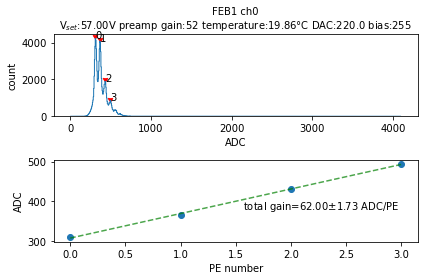

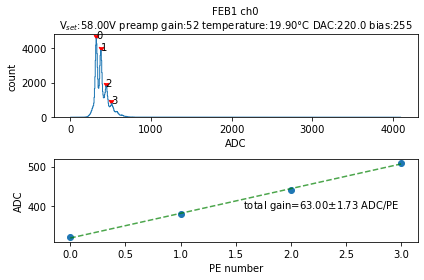

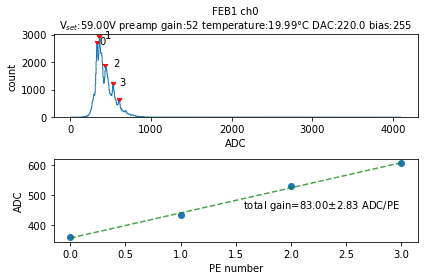

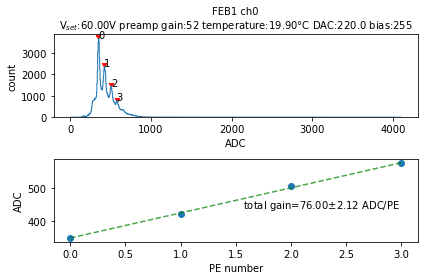

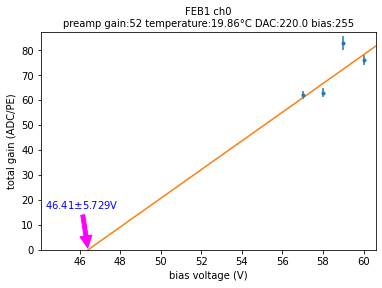

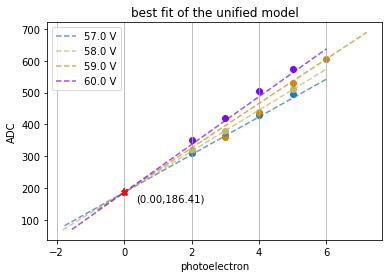

In [1]:
# my own modules
import os, sys
sys.path.insert(0, '../FEBDAQMULTx2/data_analysis/utilities')
import peak_numbering
import software_threshold_scan

# get correct peak number with the peak numbering algorithm
calib_fpns = [
    'sample_data/dark_rate_vs_photoelectron/led/20210316_135808_dark_rate_feb0_ch0_thr220.0.root',
    'sample_data/dark_rate_vs_photoelectron/led/20210316_165442_dark_rate_feb0_ch0_thr220.0.root',
    'sample_data/dark_rate_vs_photoelectron/led/20210316_184751_dark_rate_feb0_ch0_thr220.0.root',
    'sample_data/dark_rate_vs_photoelectron/led/20210317_123358_dark_rate_feb0_ch0_thr220.0.root'
]
pcb_half = 0
my_pn = peak_numbering.fitting_algorithm(calib_fpns, 1, 0, prom=100, pcb_half=pcb_half)
my_pn.fit_peak_numbering(shift_limit=4)
my_pn.refit_physics_parameters()
my_pn.plot_adc_vs_peak_number()

Now, we can construct the noise rate class.

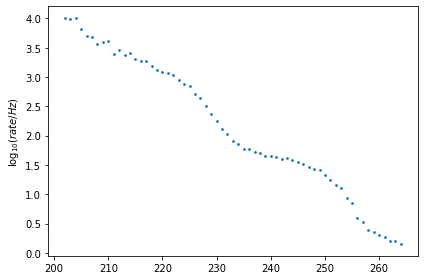

In [2]:
dark_rate_fpns = 'sample_data/dark_rate_vs_photoelectron/dark/*.root'
my_scan = software_threshold_scan.peak_number_dataframe(dark_rate_fpns, my_pn.df_3d_pts,
                                                        calib_thr=220, pcb_half=pcb_half, outpn=None)
my_scan.plot_rate_vs_dac(filtered=False)

As Hamamatsu mentions, without a high pass filter, the steepness in rate drops is flattened. However, those drops are still vaguely seen. Besides, data points fluctuate quite a bit. Now, the task is to assign photoelectron numbers to the steepest descents in the flattened, noisy curve.
## Find inflection points in a noisy curve
The steepest descents are squarely the inflection points in the curve. To find inflection points, the most naive idea is to simply differentiate the curve and find the peaks therein. So, this is the differentiated curve.

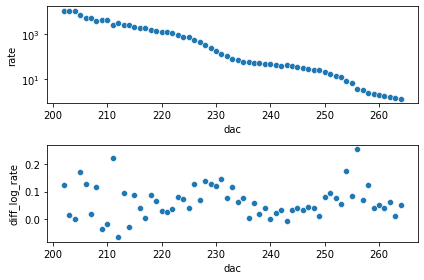

In [3]:
my_scan.plot_rate_and_diff_rate_vs_dac(filtered=False)

The top figure is the measured rates, and the bottom figure is the simple differentiation. the differentiated signal is so noisy that the peak finding algorithm I have tried fails to identify the inflection points. Some signal processing needs to be done.
## Savitzky-Golay filter
[Savitzky-Golay filter](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) is the first filter I tried to smooth the curve. The performance is so good that I don't even bother to try other solutions.

The idea of this filter is to pick a certain window that contains a certain number of data points. Then, a polynomial of a configurable degree is fit to data points in the window and the fit values are stored. Lastly, at each x value, the stored y values are averaged to obtain the smoothed curve.

Let's apply this filter to the previous figures and see how it works.

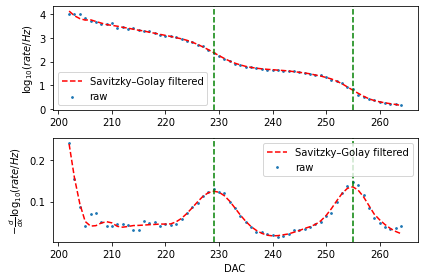

In [4]:
my_scan.plot_rate_and_diff_rate_vs_dac(filtered=True)

It can be clearly seen that peaks in the differentiated curve are so conspicuous that peak finding becomes a breezy job.
## Asign photoelectron numbers to inflection points
To make the results independent of the electronic instrument employed for measurement, the x-axis has to be calibrated to use photoelectron numbers. The idea is the following.
- Take calibration data with multiple bias voltages using thresholds at the flat region in the dart rate curve. For example, DAC 220 is a good choice.
- Apply the [peak numbering algorithm](https://github.com/kaikai581/t2k-mppc-daq/blob/master/notebooks/robust_peak_numbering.ipynb) to assign a correct photoelectron number to the first peak identified.
- In the dark rate curve, find the first inflection point with a DAC value larger than the threshold used for calibration data, and assign the first peak number found in the previous step to this inflection point.
- For all inflection points to the right of this identified one, increment photoelectron number by 1 sequentially. Similarly, decrement by 1 sequentially for those on the left.

In this example, the final result looks like this. Problem solved!

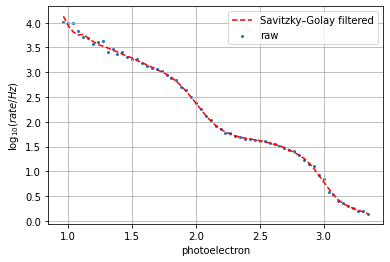

In [5]:
my_scan.dac_to_adc_and_pe()